# Descarga Masiva de datos de Yahoo Finance

In [7]:
# ── 1) Instalación (solo primera vez en Colab) ──────────────────────────────────
!pip -q install yfinance
!pip -q install openpyxl

In [2]:
# ── 2) Importaciones ────────────────────────────────────────────────────────────
import yfinance as yf
import pandas as pd
from IPython.display import display
# ── Gráficas de series de tiempo (niveles y normalizadas) ───────────────────────
import matplotlib.pyplot as plt

In [4]:
# ── 3) Definimos tickers de la BMV ──────────────────────────────────────────────
# Ejemplos (puedes mezclar USA y México .MX). Cambia/añade los que quieras.
tickers = [ 'AC.MX', 'ACCELSAB.MX', 'ACTINVRB.MX', 'AERO.MX', 'AGUILASCPO.MX',
            'AGUA.MX', 'ALFAA.MX', 'ALPEKA.MX', 'ALSEA.MX', 'AMXL.MX', 'ARA.MX',
            'ASURB.MX', 'AUTLANB.MX', 'AXTELCPO.MX', 'AZTECACPO.MX', 'BAFARB.MX',
            'BBAJIOO.MX', 'BIMBOA.MX', 'BOLSAA.MX', 'CADUA.MX', 'CEMEXCPO.MX',
            'CHDRAUIB.MX', 'CIEB.MX', 'CMRB.MX', 'COLLADO.MX', 'CONVERA.MX',
            'CUERVO.MX', 'CULTIBAB.MX', 'CYDSASAA.MX', 'DINEA.MX', 'ELEMAT.MX',
            'FEMSAUBD.MX', 'FINDEP.MX', 'FRAGUAB.MX', 'GAPB.MX', 'GCARSOA1.MX',
            'GCC.MX', 'GENTERA.MX', 'GFINBURO.MX', 'GFMULTIO.MX', 'GFNORTEO.MX',
            'GISSAA.MX', 'GMEXICOB.MX', 'GMXT.MX', 'GRUMAB.MX', 'GSANBORB-1.MX',
            'HERDEZ.MX', 'ICHB.MX', 'KIMBERA.MX', 'KOFUBL.MX', 'KUOB.MX', 'LABB.MX',
            'LALAB.MX', 'LIVEPOLC-1.MX', 'MEGACPO.MX', 'MFRISCOA-1.MX', 'NEMAKA.MX',
            'OMAB.MX', 'ORBIA.MX', 'PASAB.MX', 'PE&OLES.MX', 'PINFRA.MX',
            'POCHTECB.MX', 'Q.MX', 'RA.MX', 'RASSINICPO.MX', 'SIMECB.MX',
            'SITES1A-1.MX', 'SORIANAB.MX', 'TLEVISACPO.MX', 'VALUEGFO.MX',
            'VESTA.MX', 'VINTE.MX', 'VITROA.MX', 'VOLARA.MX', 'WALMEX.MX']

len(tickers)

76

In [5]:
# ── 4) Función para descargar y unir datos ─────────────────────────────────────
def descargar_tickers(tickers, period="5y", interval="1d", auto_adjust=True):
    """
    Descarga datos de Yahoo Finance para 1+ tickers y devuelve un DataFrame 'long'
    con columnas: Ticker, Date, OHLCV (y Adj Close si aplica).
    Maneja automáticamente columnas MultiIndex en cualquier orden.
    """
    import yfinance as yf
    import pandas as pd

    # Acepta lista o cadena ("AAPL MSFT" o "AAPL,MSFT")
    if isinstance(tickers, str):
        tickers = [t.strip() for t in tickers.replace(",", " ").split() if t.strip()]

    raw = yf.download(
        tickers=tickers,
        period=period,
        interval=interval,
        auto_adjust=auto_adjust,
        group_by="column",      # más consistente: (campo, ticker) en muchos casos
        threads=True,
        progress=False
    )

    if raw.empty:
        raise RuntimeError("No se obtuvo ningún dato. Revisa los tickers y el período.")

    # Asegurar nombre del índice de fechas
    idx_name = raw.index.name or "Date"
    raw.index.name = idx_name

    # Normalización a formato 'long'
    campos = {"Open", "High", "Low", "Close", "Adj Close", "Volume"}

    if isinstance(raw.columns, pd.MultiIndex):
        # Detectar si el nivel 0 son campos o tickers
        lvl0_vals = set(map(str, raw.columns.get_level_values(0)))
        if campos & lvl0_vals:
            # Columnas como (campo, ticker)
            datos = (raw.stack(level=1)
                         .reset_index()
                         .rename(columns={"level_1": "Ticker", idx_name: "Date"}))
        else:
            # Columnas como (ticker, campo)
            datos = (raw.stack(level=0)
                         .reset_index()
                         .rename(columns={"level_1": "Ticker", idx_name: "Date"}))
    else:
        # Un solo ticker → columnas planas
        datos = raw.reset_index().rename(columns={idx_name: "Date"})
        # Recuperar el ticker (primero de la lista)
        tk0 = tickers[0] if isinstance(tickers, (list, tuple)) else str(tickers)
        datos["Ticker"] = tk0

    # Quitar filas totalmente vacías
    value_cols = [c for c in ["Open", "High", "Low", "Close", "Adj Close", "Volume"] if c in datos.columns]
    datos = datos.dropna(subset=value_cols, how="all")

    # Orden y columnas amigables
    pref = ["Ticker", "Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]
    cols = [c for c in pref if c in datos.columns] + [c for c in datos.columns if c not in pref]
    datos = datos[cols].sort_values(["Ticker", "Date"]).reset_index(drop=True)

    return datos


In [6]:
# ── 5) Descarga ────────────────────────────────────────────────────────────────
datos = descargar_tickers(tickers, period="5y", interval="1d", auto_adjust=True)

print(f"Descargadas {datos['Ticker'].nunique()} series, {len(datos):,} filas en total.")
display(datos.head())


ERROR:yfinance:
5 Failed downloads:
ERROR:yfinance:['AMXL.MX', 'LALAB.MX', 'RASSINICPO.MX', 'ELEMAT.MX', 'GSANBORB-1.MX']: YFPricesMissingError('possibly delisted; no price data found  (period=5y) (Yahoo error = "No data found, symbol may be delisted")')


Descargadas 71 series, 86,309 filas en total.


/tmp/ipython-input-556875668.py:40: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  datos = (raw.stack(level=1)


Price,Ticker,Date,Open,High,Low,Close,Adj Close,Volume
0,AC.MX,2020-12-01,80.088813,82.370130,79.983648,81.998001,NaN,1060283.0
1,AC.MX,2020-12-02,81.965638,86.487828,81.407441,84.780884,NaN,1864111.0
2,AC.MX,2020-12-03,84.497719,84.829402,82.628982,84.344017,NaN,1233829.0
3,AC.MX,2020-12-04,84.554379,87.126929,82.968783,83.251930,NaN,1451388.0
4,AC.MX,2020-12-07,83.648301,85.525129,83.106288,84.424919,NaN,1093850.0


In [8]:
# ── 6) Guardar CSV en Colab ────────────────────────────────────────────────────
ruta_xlsx = "/content/precios_5y.xlsx"
datos.to_excel(ruta_xlsx, index=False)
print(f"✅ Archivo guardado: {ruta_xlsx}")


✅ Archivo guardado: /content/precios_5y.xlsx


In [9]:
# ── 7) Tabla ancha (Close por fecha x ticker), útil para modelos/plots ─────────
tabla_cierre = datos.pivot(index="Date", columns="Ticker", values="Close")
display(tabla_cierre.tail())

Ticker,AC.MX,ACCELSAB.MX,ACTINVRB.MX,AERO.MX,AGUA.MX,AGUILASCPO.MX,ALFAA.MX,ALPEKA.MX,ALSEA.MX,ARA.MX,...,SIMECB.MX,SITES1A-1.MX,SORIANAB.MX,TLEVISACPO.MX,VALUEGFO.MX,VESTA.MX,VINTE.MX,VITROA.MX,VOLARA.MX,WALMEX.MX
Date,,,,,,,,,,,,,,,,,,,,,
2025-11-25,183.360001,22.610001,20.670000,34.400002,12.98,61.389999,14.20,9.08,49.439999,3.31,...,177.050003,14.92,29.049999,9.99,73.5,57.389999,30.00,5.90,12.85,61.320000
2025-11-26,182.369995,22.610001,21.100000,34.080002,12.90,61.099998,14.23,9.08,49.990002,3.41,...,180.000000,15.06,29.500000,9.94,73.5,57.540001,29.99,5.88,13.19,61.689999
2025-11-27,180.539993,22.610001,20.610001,35.200001,12.99,61.000000,14.25,9.13,48.720001,3.50,...,180.000000,15.17,30.000000,9.83,73.5,56.599998,30.48,5.80,13.11,60.509998
2025-11-28,186.789993,22.170000,21.490000,35.500000,12.90,60.560001,14.42,9.09,49.939999,3.45,...,181.000000,15.00,31.400000,10.00,73.5,57.000000,30.49,5.80,13.24,61.779999
2025-12-01,186.809998,NaN,21.889999,35.119999,12.91,60.250000,14.81,8.93,49.820000,3.50,...,181.000000,15.01,30.400000,9.96,NaN,56.259998,30.49,5.80,13.42,61.200001


In [10]:
# ── 8) Resumen rápido por ticker ───────────────────────────────────────────────
resumen = (datos.groupby("Ticker")
                .agg(primer_fecha=("Date", "min"),
                     ultima_fecha=("Date", "max"),
                     n_obs=("Date", "size"))
           )
display(resumen)

,primer_fecha,ultima_fecha,n_obs
Ticker,,,
AC.MX,2020-12-01,2025-12-01,1260
ACCELSAB.MX,2020-12-01,2025-11-28,1259
ACTINVRB.MX,2020-12-01,2025-12-01,952
AERO.MX,2025-11-07,2025-12-01,16
AGUA.MX,2020-12-01,2025-12-01,1260
...,...,...,...
VESTA.MX,2020-12-01,2025-12-01,1260
VINTE.MX,2020-12-01,2025-12-01,1260
VITROA.MX,2020-12-01,2025-12-01,1260


In [11]:
# Construye la tabla ancha (Close por fecha x ticker) si no existe
if "tabla_cierre" not in globals():
    assert "datos" in globals(), "No encuentro 'datos'. Ejecuta primero la celda de descarga."
    df = datos.copy()
    df["Date"] = pd.to_datetime(df["Date"])
    tabla_cierre = (df.pivot(index="Date", columns="Ticker", values="Close")
                      .sort_index()
                      .dropna(how="all", axis=1))  # quita columnas totalmente vacías


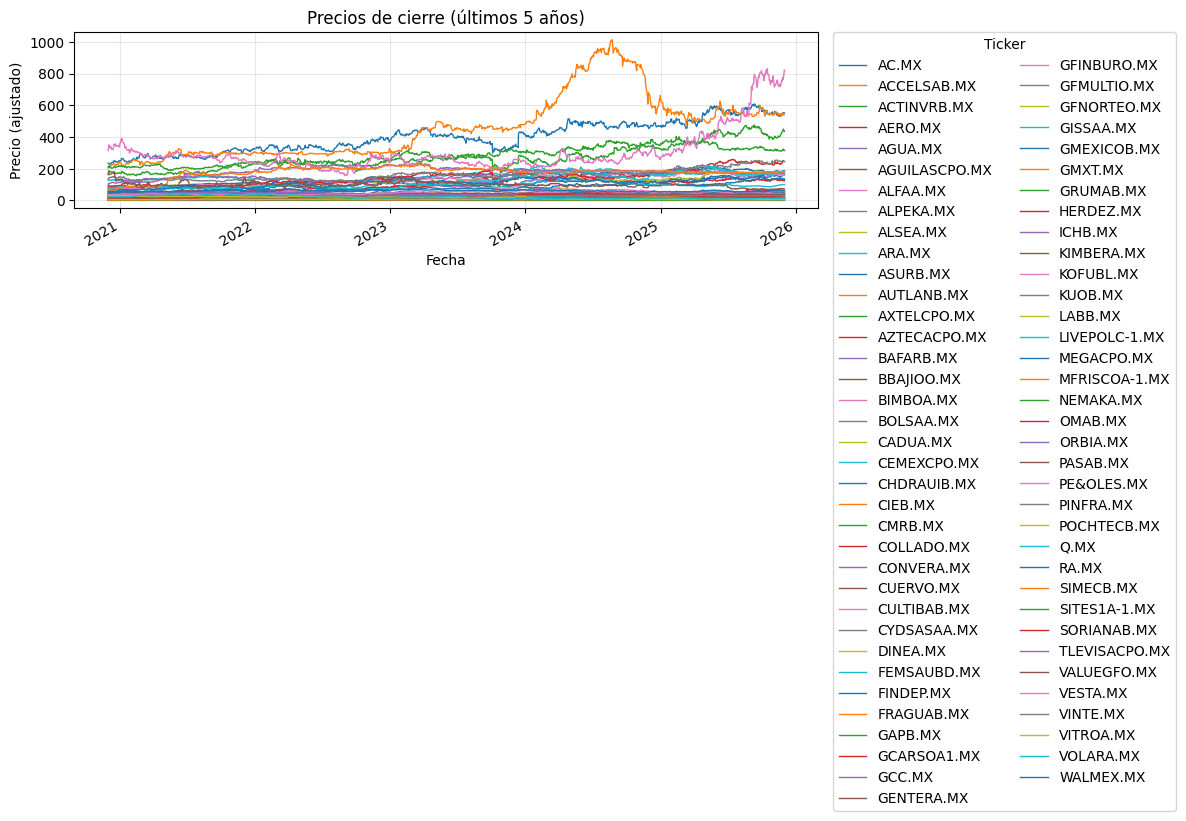

In [12]:
# ── 1) Gráfico en niveles ───────────────────────────────────────────────────────
ax = tabla_cierre.plot(figsize=(12, 6), linewidth=1)
ax.set_title("Precios de cierre (últimos 5 años)")
ax.set_xlabel("Fecha")
ax.set_ylabel("Precio (ajustado)")
ax.grid(True, alpha=0.3)
ax.legend(title="Ticker", ncol=2, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()


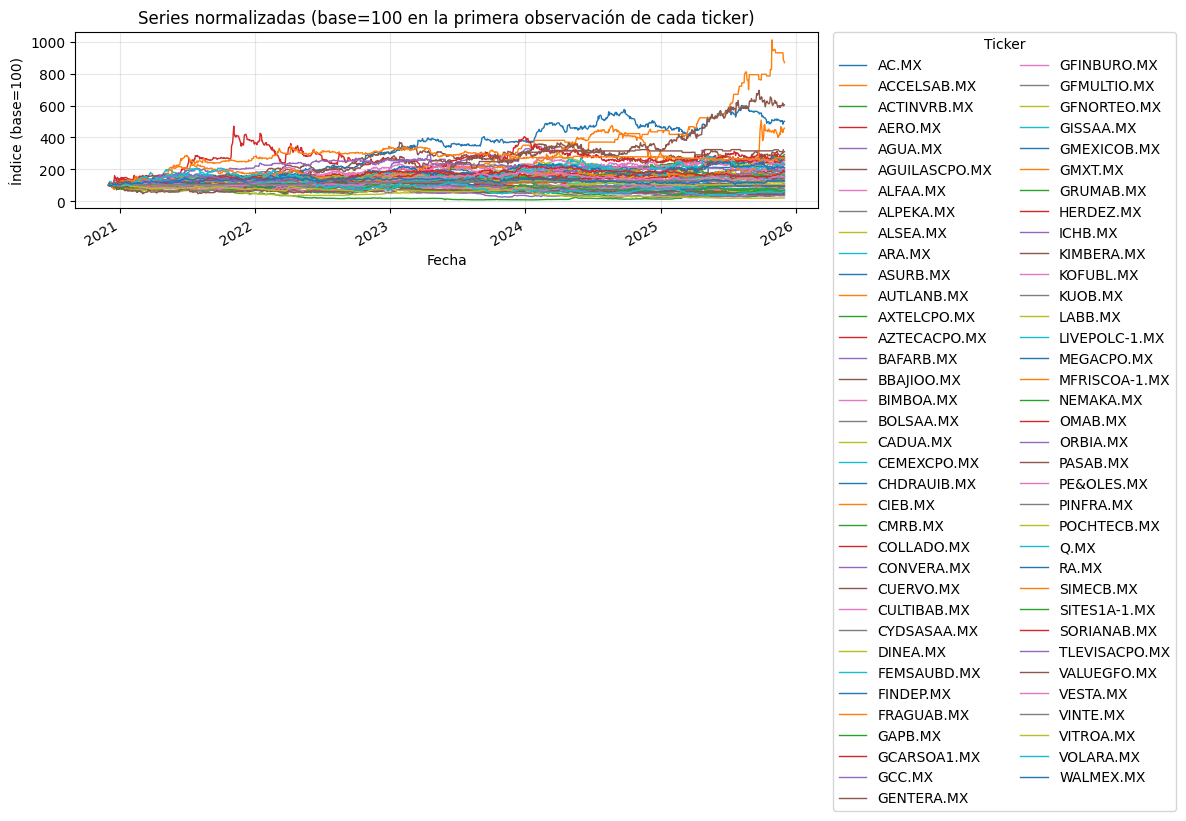

In [13]:
# ── 2) Gráfico normalizado (base=100 en la primera fecha válida de cada serie) ─
norm = tabla_cierre.apply(lambda s: s / s.dropna().iloc[0] * 100, axis=0)

ax = norm.plot(figsize=(12, 6), linewidth=1)
ax.set_title("Series normalizadas (base=100 en la primera observación de cada ticker)")
ax.set_xlabel("Fecha")
ax.set_ylabel("Índice (base=100)")
ax.grid(True, alpha=0.3)
ax.legend(title="Ticker", ncol=2, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()